# Super Resolution Inference with AMD MIGraphX
This notebook is inspired from: https://github.com/onnx/models/blob/master/vision/super_resolution/sub_pixel_cnn_2016/dependencies/Run_Super_Resolution_Model.ipynb

## Install Dependencies

In [1]:
!pip3 install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from resizeimage import resizeimage
%matplotlib inline

## Download ONNX Model

In [3]:
!wget -nc https://github.com/onnx/models/raw/master/vision/super_resolution/sub_pixel_cnn_2016/model/super-resolution-10.onnx

File ‘super-resolution-10.onnx’ already there; not retrieving.



## Import MIGraphX Python Module

In [4]:
import migraphx

# Preprocessing Image

In [5]:
orig_img = Image.open("./ROCmlogo.jpg")
print(orig_img.size)
img = resizeimage.resize_cover(orig_img, [224,224], validate=False)
img_ycbcr = img.convert('YCbCr')
img_y_0, img_cb, img_cr = img_ycbcr.split()
img_ndarray = np.asarray(img_y_0)

img_4 = np.expand_dims(np.expand_dims(img_ndarray, axis=0), axis=0)
img_5 = img_4.astype(np.float32) / 255.0
img_5

(128, 131)


array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]], dtype=float32)

# Run Model

In [6]:
model = migraphx.parse_onnx("super-resolution-10.onnx")
model.compile(migraphx.get_target("gpu"))
#model.print()

print(model.get_parameter_names())
print(model.get_parameter_shapes())


result = model.run({
         "input": img_5
     })

data = np.array(result[0])[0]

['input']
{'input': float_type, {1, 1, 224, 224}, {50176, 50176, 224, 1}}


# Postprocessing Image

(672, 672)


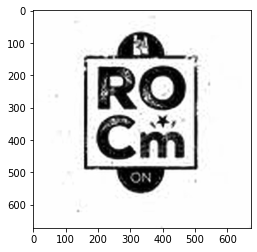

In [7]:
img_out_y = Image.fromarray(np.uint8((data* 255.0).clip(0, 255)[0]), mode='L')
# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")
plt.imshow(final_img)
final_img.save("output.jpg")
print(final_img.size)